Анализ синтетического датасета для проекта

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Генерация синтетических данных

In [28]:
np.random.seed(42)
n_samples = 1000

client_id - целое число, уникальный идентификатор клиента. 
age - число, возраст клиента в годах. 
gender - категориальная переменная, пол клиента. 
region - категориальная переменная, географический регион. Значения: 'Moscow', 'SPb', 'Other'. 
segment - маркетинговый сегмент клиента. Значения: 'new' (новые), 'active' (активные), 'loyal' (лояльные), 'sleeping' (спящие). 
avg_purchase - число, средний чек клиента в рублях.
days_since_last_purchase - целое число, количество дней с последней покупки. 

In [29]:
# Базовые признаки клиентов
data = {
    'client_id': range(1, 1 + n_samples),
    'age': np.random.randint(18, 70, n_samples).astype(float),
    'gender': np.random.choice(['M', 'F'], n_samples, p=[0.48, 0.52]),
    'region': np.random.choice(['Moscow', 'SPb', 'Other'], n_samples, p=[0.4, 0.3, 0.3]),
    'segment': np.random.choice(['new', 'active', 'loyal', 'sleeping'], n_samples, p=[0.2, 0.4, 0.3, 0.1]),
    'avg_purchase': np.round(np.random.exponential(3000, n_samples), 2),
    'days_since_last_purchase': np.random.randint(1, 365, n_samples)
}

channel - категориальная переменная, канал отправки сообщения. Значения: 'email', 'push', 'sms', 'social'. 
content_type - категориальная переменная, тип контента в сообщении. Значения: 'discount' (скидка), 'new_product' (новый товар), 'blog' (статья), 'event' (мероприятие), 'personal_offer' (персональное предложение). 

In [30]:
channels = ['email', 'push', 'sms', 'social']
content_types = ['discount', 'new_product', 'blog', 'event', 'personal_offer']

In [31]:
data['channel'] = np.random.choice(channels, n_samples, p=[0.4, 0.3, 0.2, 0.1])
data['content_type'] = np.random.choice(content_types, n_samples)

opened - бинарная переменная, открыл ли клиент сообщение. Значения: 0 (нет), 1 (да). 
clicked - бинарная переменная, кликнул ли клиент на ссылку/кнопку в сообщении. Значения: 0, 1. 
converted - бинарная переменная, совершил ли клиент покупку после клика. Значения: 0, 1. 

In [32]:
# Целевая переменная и метрики
data['opened'] = np.random.binomial(1, 0.3, n_samples)  # Открыли
data['clicked'] = data['opened'] * np.random.binomial(1, 0.4, n_samples)  # Кликнули
data['converted'] = data['clicked'] * np.random.binomial(1, 0.15, n_samples)  # Конвертировали


In [33]:
df = pd.DataFrame(data)

Делаем данные более реалистичными

In [34]:
# Возраст влияет на средний чек (старшие клиенты покупают дороже)
# Создаем базовый чек и добавляем возрастной коэффициент
df['avg_purchase'] = np.random.exponential(2000, n_samples) + df['age'] * 50

# Активные клиенты покупают чаще (меньше дней между покупками)
segment_to_days = {
    'new': np.random.randint(1, 30, n_samples),
    'active': np.random.randint(1, 15, n_samples),
    'loyal': np.random.randint(1, 30, n_samples),
    'sleeping': np.random.randint(60, 365, n_samples)
}
df['days_since_last_purchase'] = df['segment'].map(lambda x: np.random.choice(segment_to_days[x]))

In [35]:
# Более реалистичное распределение возраста (нормальное распределение)
df['age'] = np.random.normal(45, 15, n_samples).astype(int)
df['age'] = df['age'].clip(18, 75)  # Ограничиваем разумные границы

# Региональные различия в среднем чеке
region_multiplier = {
    'Moscow': 1.5,
    'SPb': 1.3,
    'Other': 1.0
}
df['avg_purchase'] = df['avg_purchase'] * df['region'].map(region_multiplier)

In [36]:
# Время отправки зависит от возраста
df['send_hour'] = np.where(
    df['age'] < 30,
    np.random.choice([18, 19, 20, 21, 22], n_samples),  # Молодежь вечером
    np.random.choice([10, 11, 12, 13, 14], n_samples)   # Взрослые днем
)

# Тип контента зависит от сегмента
segment_content = {
    'new': ['discount', 'new_product'],
    'active': ['discount', 'event', 'personal_offer'],
    'loyal': ['personal_offer', 'event'],
    'sleeping': ['discount', 'new_product']
}
df['content_type'] = df['segment'].apply(lambda x: np.random.choice(segment_content[x]))

# Канал зависит от возраста
df['channel'] = np.where(
    df['age'] < 35,
    np.random.choice(['push', 'social', 'email'], n_samples, p=[0.4, 0.3, 0.3]),
    np.random.choice(['email', 'sms', 'push'], n_samples, p=[0.5, 0.3, 0.2])
)

In [37]:
# Базовые вероятности с учетом сегмента
segment_conversion = {
    'new': 0.08,
    'active': 0.20,
    'loyal': 0.25,
    'sleeping': 0.05
}

# Увеличиваем вероятность для персонализированных офферов
content_multiplier = {
    'personal_offer': 1.8,
    'discount': 1.5,
    'event': 1.2,
    'new_product': 1.1,
    'blog': 1.0
}

# Рассчитываем итоговую вероятность
df['base_prob'] = df['segment'].map(segment_conversion) * df['content_type'].map(content_multiplier)

# Добавляем шум и ограничиваем
df['conversion_prob'] = df['base_prob'] + np.random.normal(0, 0.05, n_samples)
df['conversion_prob'] = df['conversion_prob'].clip(0.01, 0.5)

# Генерируем конверсии
df['converted'] = np.random.binomial(1, df['conversion_prob'])

# Цепочка событий (сначала открыли, потом кликнули, потом конвертировали)
df['opened'] = np.where(
    df['converted'] == 1,
    1,  # если конвертировал, то точно открыл
    np.random.binomial(1, 0.25)  # базовая вероятность открытия
)

df['clicked'] = np.where(
    df['opened'] == 1,
    np.random.binomial(1, 0.4 + df['conversion_prob'] * 0.3),  # выше вероятность если открыл
    0
)

In [38]:
# Рабочие vs выходные дни
df['is_weekend'] = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])

# Время суток влияет на открытие
df['opened'] = np.where(
    (df['send_hour'] >= 18) & (df['send_hour'] <= 22),
    np.random.binomial(1, 0.35),  # вечером выше
    np.random.binomial(1, 0.25)   # днем ниже
)

In [41]:
# Добавляем пропущенные значения (как в реальных данных)
missing_mask = np.random.random(n_samples) < 0.05
df.loc[missing_mask, 'age'] = np.nan
# 1. Отрицательные покупки (5 случайных клиентов)
neg_indices = np.random.choice(df.index, size=5, replace=False)
df.loc[neg_indices, 'avg_purchase'] = -100

# 2. Невозрастной возраст (3 случайных клиента)
age_indices = np.random.choice(df.index, size=3, replace=False)
df.loc[age_indices, 'age'] = 150
    


Вывод 5 строк

In [42]:
df.head()

,client_id,age,gender,region,segment,avg_purchase,days_since_last_purchase,channel,content_type,opened,clicked,converted,send_hour,base_prob,conversion_prob,is_weekend
0,1,22.0,F,Moscow,sleeping,4427.302660,342,push,new_product,1,0,0,18,0.055,0.094106,1
1,2,18.0,M,Moscow,loyal,10338.222647,3,push,event,1,0,1,19,0.300,0.286050,0
2,3,NaN,M,Other,sleeping,3658.627102,360,email,discount,0,0,0,13,0.075,0.151214,0
3,4,40.0,M,Other,loyal,5351.800478,15,push,personal_offer,0,0,0,13,0.450,0.402493,0
4,5,28.0,M,SPb,active,6287.168889,5,social,event,1,1,1,20,0.240,0.210959,1


Информация о столбцах и типах

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 1000 non-null   int64  
 1   age                       858 non-null    float64
 2   gender                    1000 non-null   object 
 3   region                    1000 non-null   object 
 4   segment                   1000 non-null   object 
 5   avg_purchase              1000 non-null   float64
 6   days_since_last_purchase  1000 non-null   int32  
 7   channel                   1000 non-null   object 
 8   content_type              1000 non-null   object 
 9   opened                    1000 non-null   int64  
 10  clicked                   1000 non-null   int32  
 11  converted                 1000 non-null   int32  
 12  send_hour                 1000 non-null   int64  
 13  base_prob                 1000 non-null   float64
 14  conversio

Базовая описательная статистика

In [44]:
df.describe()

,client_id,age,avg_purchase,days_since_last_purchase,opened,clicked,converted,send_hour,base_prob,conversion_prob,is_weekend
count,1000.000000,858.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,500.500000,45.944056,5342.490829,30.116000,0.172000,0.131000,0.268000,13.34200,0.261295,0.260075,0.30600
std,288.819436,18.014428,2910.024362,63.295915,0.377569,0.337569,0.443139,3.33769,0.124279,0.132903,0.46106
min,1.000000,18.000000,-100.000000,1.000000,0.000000,0.000000,0.000000,10.00000,0.055000,0.010000,0.00000
25%,250.750000,35.000000,3426.680623,6.000000,0.000000,0.000000,0.000000,11.00000,0.120000,0.149086,0.00000
50%,500.500000,45.000000,4784.675033,11.000000,0.000000,0.000000,0.000000,12.00000,0.300000,0.276672,0.00000
75%,750.250000,56.000000,6628.968338,21.000000,0.000000,0.000000,1.000000,14.00000,0.360000,0.360984,1.00000
max,1000.000000,150.000000,21815.933949,361.000000,1.000000,1.000000,1.000000,22.00000,0.450000,0.500000,1.00000


Проверка дубликатов

In [45]:
df.duplicated().sum()

np.int64(0)

Проверка на аномальные значения( большой возраст и отрицательные покупки)

In [46]:
df[(df['age'] < 18) | (df['age'] > 100)]

,client_id,age,gender,region,segment,avg_purchase,days_since_last_purchase,channel,content_type,opened,clicked,converted,send_hour,base_prob,conversion_prob,is_weekend
141,142,150.0,F,SPb,new,4271.485483,20,email,discount,0,0,0,13,0.12,0.158916,0
216,217,150.0,M,Other,new,3570.596096,10,email,discount,0,0,0,12,0.12,0.158951,1
228,229,150.0,M,Other,active,1176.076215,11,push,personal_offer,0,0,1,10,0.36,0.395137,1
282,283,150.0,F,Moscow,active,5966.135475,9,sms,discount,0,0,0,11,0.30,0.330202,1
325,326,150.0,F,SPb,active,16195.080478,14,email,event,0,0,0,12,0.24,0.175524,0
378,379,150.0,F,SPb,loyal,-100.000000,2,email,personal_offer,0,1,1,12,0.45,0.500000,0
580,581,150.0,M,Other,new,3552.397246,4,push,discount,1,0,0,19,0.12,0.181839,0
804,805,150.0,F,SPb,active,3667.472110,5,social,personal_offer,0,0,0,12,0.36,0.341760,0
841,842,150.0,F,Other,active,2262.751028,1,push,discount,0,0,1,11,0.30,0.309932,0


In [47]:
df[df['avg_purchase']<0]

,client_id,age,gender,region,segment,avg_purchase,days_since_last_purchase,channel,content_type,opened,clicked,converted,send_hour,base_prob,conversion_prob,is_weekend
50,51,44.0,F,Other,new,-100.0,17,sms,new_product,0,0,0,12,0.088,0.067263,0
64,65,37.0,F,Other,active,-100.0,14,push,discount,0,0,0,10,0.300,0.144374,0
206,207,NaN,M,SPb,sleeping,-100.0,221,push,discount,0,0,0,14,0.075,0.149364,0
210,211,NaN,M,Moscow,loyal,-100.0,21,email,personal_offer,0,1,1,13,0.450,0.369346,0
332,333,45.0,F,Moscow,sleeping,-100.0,73,push,discount,0,0,0,14,0.075,0.017269,0
371,372,23.0,F,Other,new,-100.0,26,social,new_product,1,0,0,22,0.088,0.028115,0
378,379,150.0,F,SPb,loyal,-100.0,2,email,personal_offer,0,1,1,12,0.450,0.500000,0
418,419,37.0,F,Other,loyal,-100.0,21,push,event,0,0,0,14,0.300,0.291014,0
527,528,66.0,F,Other,active,-100.0,1,email,discount,0,0,0,11,0.300,0.360577,1
673,674,40.0,F,Moscow,active,-100.0,5,email,event,0,0,0,11,0.240,0.314717,1


Проверка на пропуски

In [48]:
df.isnull().sum()

client_id                     0
age                         142
gender                        0
region                        0
segment                       0
avg_purchase                  0
days_since_last_purchase      0
channel                       0
content_type                  0
opened                        0
clicked                       0
converted                     0
send_hour                     0
base_prob                     0
conversion_prob               0
is_weekend                    0
dtype: int64

Постороение графиков

Гистограмма распределения возраста

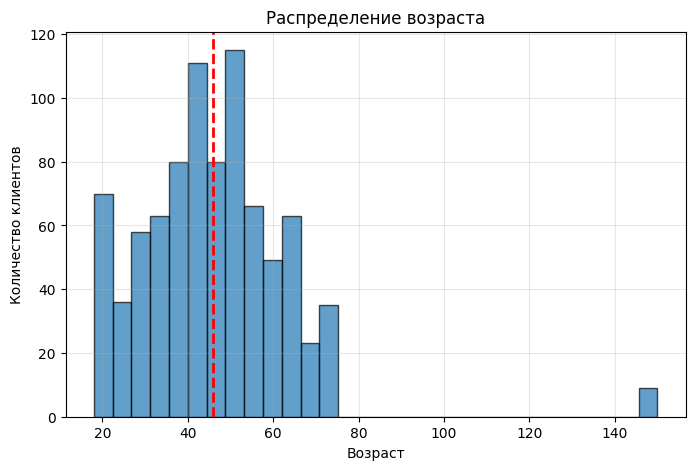

In [49]:
# 1. ГИСТОГРАММА распределения возраста
plt.figure(figsize=(8, 5))
plt.hist(df['age'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(df['age'].mean(), color='red', linestyle='--', linewidth=2)
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.title('Распределение возраста')
plt.grid(True, alpha=0.3)
plt.show()

Вывод по графику распределения возраста:

Основная группа клиентов - 30-60 лет (пик около 45 лет)

Есть аномалии - несколько клиентов с возрастом 150 лет (ошибки в данных)

Распределение близко к нормальному с небольшим смещением вправо

Молодых клиентов (18-25) заметно меньше, чем средней возрастной группы

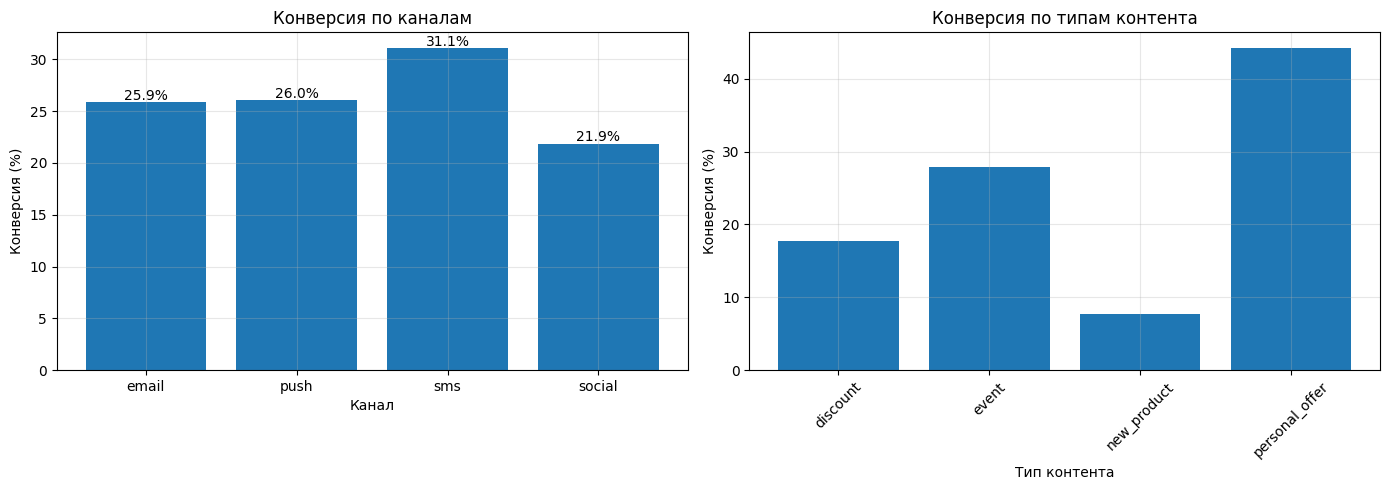

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Конверсия по каналам
conversion_by_channel = df.groupby('channel')['converted'].mean() * 100
axes[0].bar(conversion_by_channel.index, conversion_by_channel.values)
axes[0].set_xlabel('Канал')
axes[0].set_ylabel('Конверсия (%)')
axes[0].set_title('Конверсия по каналам')
axes[0].grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, v in enumerate(conversion_by_channel.values):
    axes[0].text(i, v + 0.2, f'{v:.1f}%', ha='center')

# Конверсия по типам контента
conversion_by_content = df.groupby('content_type')['converted'].mean() * 100
axes[1].bar(conversion_by_content.index, conversion_by_content.values)
axes[1].set_xlabel('Тип контента')
axes[1].set_ylabel('Конверсия (%)')
axes[1].set_title('Конверсия по типам контента')
axes[1].grid(True, alpha=0.3)

# Поворачиваем подписи для читаемости
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

У всех каналов хорошая конверсия
Наилучший канал sms
В типах контента наилучшее решение личный оффер

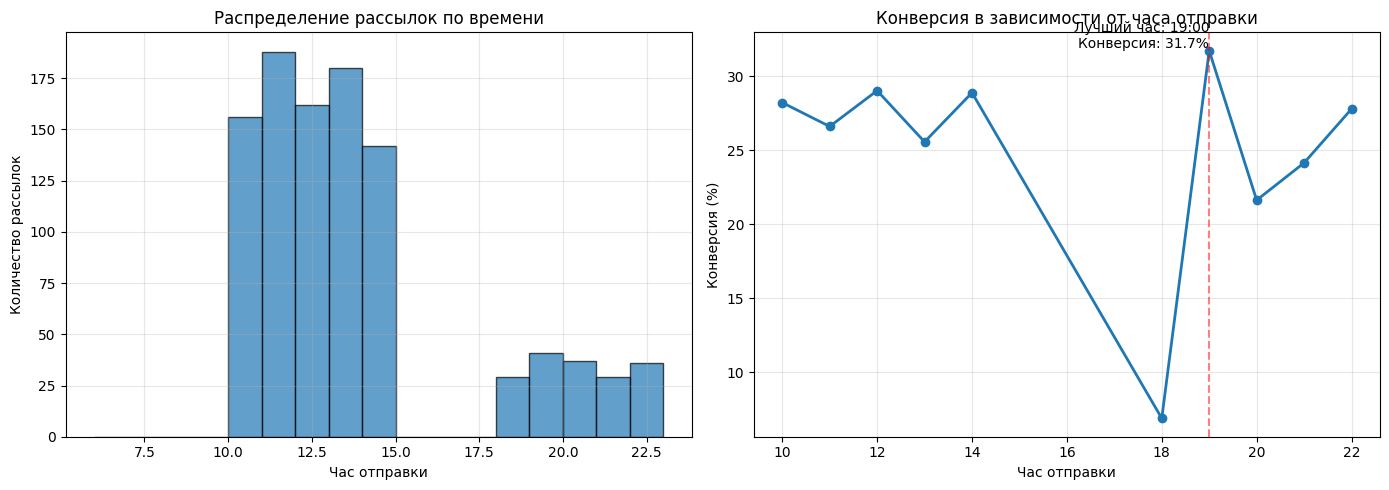

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма времени отправки
axes[0].hist(df['send_hour'], bins=range(6, 24), edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Час отправки')
axes[0].set_ylabel('Количество рассылок')
axes[0].set_title('Распределение рассылок по времени')
axes[0].grid(True, alpha=0.3)

# Конверсия по часам
conversion_by_hour = df.groupby('send_hour')['converted'].mean() * 100
axes[1].plot(conversion_by_hour.index, conversion_by_hour.values, marker='o', linewidth=2)
axes[1].set_xlabel('Час отправки')
axes[1].set_ylabel('Конверсия (%)')
axes[1].set_title('Конверсия в зависимости от часа отправки')
axes[1].grid(True, alpha=0.3)

# Подсвечиваем лучшие часы
best_hour = conversion_by_hour.idxmax()
best_value = conversion_by_hour.max()
axes[1].axvline(best_hour, color='red', linestyle='--', alpha=0.5)
axes[1].text(best_hour, best_value, f'Лучший час: {best_hour}:00\nКонверсия: {best_value:.1f}%', 
             ha='right', va='bottom')

plt.tight_layout()
plt.show()

Наилучший час рассылки это 19

Конверсия (%) по каналам и типам контента:
content_type  discount  event  new_product  personal_offer
channel                                                   
email             16.1   24.8          7.7            45.3
push              17.8   30.0          8.6            38.8
sms               16.4   34.8          9.4            54.4
social            38.5   15.8          0.0            27.3


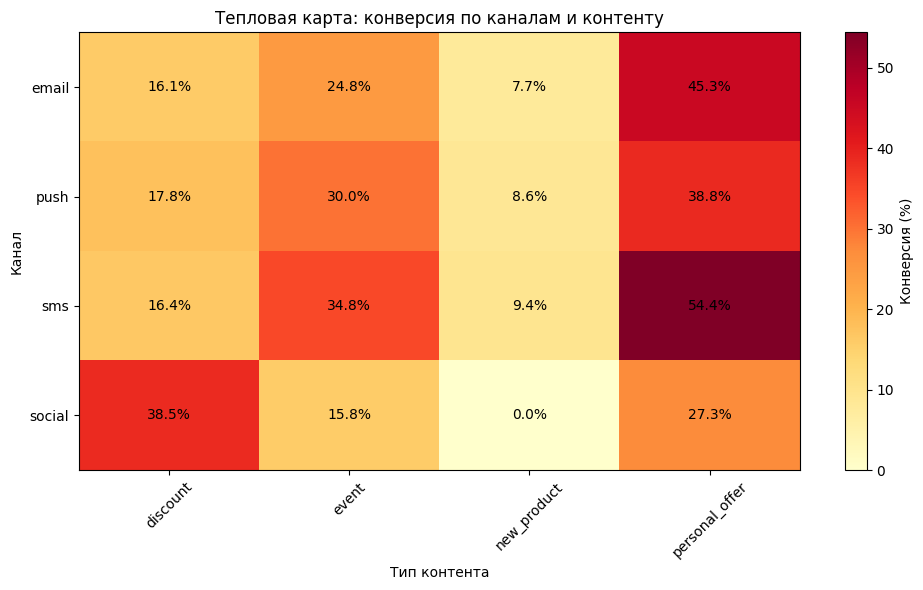

In [56]:
# Группировка по двум признакам
pivot_table = pd.pivot_table(df, 
                            values='converted', 
                            index='channel', 
                            columns='content_type', 
                            aggfunc='mean') * 100

print("Конверсия (%) по каналам и типам контента:")
print(pivot_table.round(1))

# Визуализация pivot table
plt.figure(figsize=(10, 6))
plt.imshow(pivot_table, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Конверсия (%)')
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns, rotation=45)
plt.yticks(range(len(pivot_table.index)), pivot_table.index)
plt.xlabel('Тип контента')
plt.ylabel('Канал')
plt.title('Тепловая карта: конверсия по каналам и контенту')

# Добавляем значения в ячейки
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        plt.text(j, i, f'{pivot_table.iloc[i, j]:.1f}%', 
                 ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

Наилучшие комбинации sms+offer(54)
email + offer(45)
push + offer(38)
Наихудшие комбинации 
Social + new_product(0)
email+new_product(7)
push+new_product(8)


Ключевые вывод:
Основная аудитория: 30-60 лет (пик ~45 лет)
sms наилучшая конверсия
personal_offer - лучшая контент стратегия
19:00 - наилучшее время отправки 